# BenchMD Tutorial: Dermascopic Images

In this tutorial, we will demonstrate the full training pipeline for generating results on the dermascopic images modality, including how to manipulate the associated config files, generate statistics on datasets, and train+test a model.

In [1]:
import argparse
import yaml
from torchvision import transforms

import torchvision.transforms as T
from PIL import Image
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.datasets.catalog import DATASET_DICT

import warnings
warnings.filterwarnings('ignore')

/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The default config files for training are under the ``/conf`` directory, including the training config files ``./conf/pretrain.yaml`` and ``./conf/transfer.py``, as well as config files for each dataset. Below, we demonstrate the structure of the config files, and how to load a particular dermascopic dataset, ISIC 2019.

In [2]:
with open('./conf/pretrain.yaml') as f:
    config= yaml.safe_load(f)
print(config)

dataset = "isic2019"

train_ds_kwargs = {"base_root": config["data_root"], "download": True, "train": True}
val_ds_kwargs = {"base_root": config["data_root"], "download": True, "train": False}

dataset = DATASET_DICT[dataset]
train_dataset = dataset(**train_ds_kwargs)
val_dataset = dataset(**val_ds_kwargs)

{'algorithm': 'emix', 'shed_frac': 0.85, 'data_root': '/home/ubuntu/2022-spr-benchmarking/src/datasets/', 'gpus': 0, 'exp': {'base_dir': '/home/ubuntu/res/', 'name': '???'}, 'trainer': {'weights_summary': 'top', 'seed': 0, 'val_check_interval': 1.0, 'limit_val_batches': 1.0, 'resume_from_checkpoint': None, 'precision': 16, 'max_steps': 100000, 'gradient_clip_val': 0, 'shed_frac': 0.85}, 'optim': {'name': 'adam', 'lr': 0.0001, 'weight_decay': 0.0001, 'momentum': 0.9}, 'defaults': [{'dataset': 'mimic-cxr'}, {'model': 'transformer'}]}
Building index...
Done
Building index...
Done


Next, we generate summary statistics on the dataset, including the mean and standard deviation of the training (which can be used to standardize datasets) and distribution of modality labels for ISIC 2019. Note, however, that we already standardize and pad the dataset elsewhere in this repo, so this code serves mostly as a reference for transforming your new datasets. 

In [3]:
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    num_workers=8,
    shuffle=False,
    drop_last=False,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    num_workers=8,
    shuffle=False,
    drop_last=False,
    pin_memory=True,
)

psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])
train_labels = []
val_labels = []
count = 0
for ind, images, label in tqdm(train_loader):
    psum += images.sum(axis=[0, 2, 3])
    psum_sq += (images**2).sum(axis=[0, 2, 3])
    count += images.shape[0] * images.shape[2] * images.shape[3]
    train_labels.append(label.item())

for ind, images, label in tqdm(val_loader):
    val_labels.append(label.item())

# mean and std
total_mean = psum / count
total_var = (psum_sq / count) - (total_mean**2)
total_std = torch.sqrt(total_var)

# output
print(f'train mean: {total_mean}')
print(f'train std: {total_std}')
train_label_freq = torch.histogram(torch.tensor(train_labels, dtype=torch.float32), bins=train_dataset.NUM_CLASSES).hist
train_label_dist = torch.histogram(
    torch.tensor(train_labels, dtype=torch.float32), bins=train_dataset.NUM_CLASSES, density=True
).hist
train_label_dist = train_label_dist / train_label_dist.sum()

val_label_freq = torch.histogram(torch.tensor(val_labels, dtype=torch.float32), bins=train_dataset.NUM_CLASSES).hist
val_label_dist = torch.histogram(
    torch.tensor(val_labels, dtype=torch.float32), bins=train_dataset.NUM_CLASSES, density=True
).hist
val_label_dist = val_label_dist / val_label_dist.sum()

print(f'train label frequencies ({train_dataset.NUM_CLASSES} classes): {train_label_freq}')
print(f'train label distribution ({train_dataset.NUM_CLASSES} classes): {train_label_dist}')
print(f'val label frequencies ({train_dataset.NUM_CLASSES} classes): {val_label_freq}')
print(f'val label distribution ({train_dataset.NUM_CLASSES} classes): {val_label_dist}')

  1%|▏                  | 180/20265 [00:01<03:23, 98.66it/s]


KeyboardInterrupt: 

An example of a raw image from the training set.

Building index...
Done


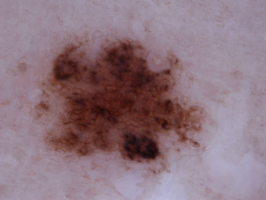

In [46]:
transform = transforms.Resize(200)
train_dataset.build_index()
fname = train_dataset.fnames[0]
img = transform(Image.open(fname).convert('RGB'))
display(img)

To demonstrate the training pipeline, we will train our model for several epochs (2000 steps, when the first automatic checkpoint is saved). Below, we will export to environment variables the command line arguments for Hydra. Path variables should be modified to suit your system.


In [18]:
# Dataset for pretraining. The source dataset for the dermascopic images modality is ISIC2019.
%env source_ds=isic2019

# Max steps to run pretraining. Our script automatically checkpoints every 2000 steps, 
# which is roughly 5 epochs of training on ISIC2019.
%env pt_steps=2000

# Algorithm for pretraining. Choose from emix, shed, and mae.
%env alg=emix

# Base directory for checkpointing. You should modify this to a suitable existing directory on your system!
%env base_dir=/home/ubuntu/tutorial/

#Experiment name; also the sub-directory under the base directory where checkpoints will be stored.
%env pt_exp_name=tutorial-derm-emix

env: source_ds=isic2019
env: pt_steps=2000
env: alg=emix
env: base_dir=/home/ubuntu/tutorial/
env: pt_exp_name=tutorial-derm-emix


In [6]:
!(python pretrain.py \
  dataset=$source_ds \
  trainer.max_steps=$pt_steps \
  algorithm=$alg \
  exp.base_dir=$base_dir \
  exp.name=$pt_exp_name)

pretrain.py:6: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='conf', config_name='pretrain')
/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'pretrain': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/core/default_element.py:124: UserWarning: In 'model/transformer': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(
/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/core/default_element.py:124: UserWarning: In 'dataset/isic2019': Usage of deprecated keyword in package 

Epoch 2:  97%|▉| 386/396 [01:08<00:01,  5.63it/s, loss=2.04, v_num=yo7b, val_acc
Epoch 2:  98%|▉| 388/396 [01:08<00:01,  5.65it/s, loss=2.04, v_num=yo7b, val_acc
Epoch 2:  98%|▉| 390/396 [01:09<00:01,  5.61it/s, loss=2.04, v_num=yo7b, val_acc
Epoch 2:  99%|▉| 392/396 [01:09<00:00,  5.61it/s, loss=2.04, v_num=yo7b, val_acc
Epoch 2:  99%|▉| 394/396 [01:10<00:00,  5.62it/s, loss=2.04, v_num=yo7b, val_acc
Epoch 2: 100%|█| 396/396 [01:10<00:00,  5.64it/s, loss=2.04, v_num=yo7b, val_acc
Epoch 3:  80%|▊| 316/396 [00:58<00:14,  5.43it/s, loss=1.99, v_num=yo7b, val_acc
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/80 [00:00<?, ?it/s]
Epoch 3:  80%|▊| 318/396 [00:59<00:14,  5.36it/s, loss=1.99, v_num=yo7b, val_acc
Epoch 3:  81%|▊| 320/396 [00:59<00:14,  5.38it/s, loss=1.99, v_num=yo7b, val_acc
Epoch 3:  81%|▊| 322/396 [00:59<00:13,  5.40it/s, loss=1.99, v_num=yo7b, val_acc
Epoch 3:  82%|▊| 324/396 [00:59<00:13,  5.43it/s, loss=1.99, v_num=yo7b, val_a

We should now have a pretraining checkpoint named ``epoch6-step1999.ckpt`` stored under the specified ``base_dir/pt_exp_name``, which can now be used for transfer learning (still on the source dataset, ISIC2019) on the 5-class task we have defined for the dermascopic images modality. First, we will run linear evaluation for 1 epoch on the pretrained checkpoint, using all labels in the source dataset.

Below, we will export to environment variables the command line arguments for Hydra. We encourage you to experiment with these variables.

In [22]:
# Max epochs to run pretraining. Our script automatically checkpoints every 2000 steps, 
# which is roughly 5 epochs of training on ISIC2019.
%env transfer_epochs=1

# Experiment name; also the sub-directory under the base directory where checkpoints will be stored.
%env lineval_exp_name=tutorial-derm-emix-lineval

# Pretraining checkpoint location. You should modify this to match the path on your system.
%env pt_ckpt=/home/ubuntu/tutorial/tutorial-derm-emix/epoch6-step1999.ckpt

env: transfer_epochs=1
env: lineval_exp_name=tutorial-derm-emix-lineval
env: pt_ckpt=/home/ubuntu/tutorial/tutorial-derm-emix/epoch6-step1999.ckpt


In [17]:
!(python transfer.py \
  dataset=$source_ds \
  trainer.max_epochs=$transfer_epochs \
  exp.base_dir=$base_dir \
  exp.name=$lineval_exp_name \
  ckpt=$pt_ckpt)


/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'transfer': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/core/default_element.py:124: UserWarning: In 'model/transformer': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(
/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/core/default_element.py:124: UserWarning: In 'dataset/isic2019': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(
/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/_internal

Alternatively, we can also perform finetuning (again, for 1 epoch) on the pretrained model by passing in an addition argument, ``finetune_size``, which we can set to either ``small`` (8 labels/class), ``medium`` (64 labels/class), ``large`` (256 labels/class), or ``full`` (all labels), depending on how many labels we want to use for finetuning.

In [23]:
# Finetune size
%env f_size=small

# Experiment name; also the sub-directory under the base directory where checkpoints will be stored.
%env finetune_exp_name=tutorial-derm-emix-finetune

env: f_size=small
env: finetune_exp_name=tutorial-derm-emix-finetune


In [24]:
!(python transfer.py \
  dataset=$source_ds \
  trainer.max_epochs=$transfer_epochs \
  finetune_size=$f_size \
  exp.base_dir=$base_dir \
  exp.name=$finetune_exp_name \
  ckpt=$pt_ckpt)


/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'transfer': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/core/default_element.py:124: UserWarning: In 'model/transformer': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(
/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/core/default_element.py:124: UserWarning: In 'dataset/isic2019': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(
/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/_internal

There should be transfer learning checkpoints stored under the specified experiment names, which can now be used for evaluation on the target datasets, HAM10000 and PAD-UFES-20. Run testing by passing in an additional argument ``test=True`` and specifying the transfer learning checkpoint you'd like to use.

In [33]:
# Pretraining checkpoint location. You should modify this to select the checkpoint you'd like to use on your system.
%env ckpt_to_test=/home/ubuntu/tutorial/tutorial-derm-emix-lineval/best_model_epoch0.ckpt

# Test dataset
%env test1=ham10000

# Test dataset
%env test2=pad_ufes_20

env: ckpt_to_test=/home/ubuntu/tutorial/tutorial-derm-emix-lineval/best_model_epoch0.ckpt
env: test1=ham10000
env: test2=pad_ufes_20


In [37]:
!(python transfer.py \
  test=True \
  dataset=$test_ds_1 \
  exp.base_dir=$base_dir \
  exp.name="tutorial-test-derm" \
  ckpt=$ckpt_to_test)

/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'transfer': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/core/default_element.py:124: UserWarning: In 'model/transformer': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(
/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/core/default_element.py:124: UserWarning: In 'dataset/ham10000': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(
/home/ubuntu/.conda/envs/dabs2/lib/python3.8/site-packages/hydra/_internal